# Hands-on session II: Playing with Gaia DR2 and DR3 data
Tutor: S. Roca-Fàbrega, D. Hatzidimitriou

In order for this tutorial to run, you need to have the conda environment "Athens2022" working on your PC.
To do that you should follow the instructions in https://github.com/Santiastro1/Athens_School_2022/blob/main/README.md

### Preparing working folders and data

Once you have your environment installed and working, check that you already have a folder called "Athens_School_2022" in your $HOME (you should if you followed the instructions to create the conda environment, see instructions above this paragraph), and a "HandsOnII" (you are suposed to be inside it if you are reading this notebook).

Now you need to get the data from Google Drive (it will be downloaded in your ~/Downloads folder): 

    https://drive.google.com/drive/folders/1fxBK3qycT1fFmouz9JmIMw1mkAznfv1v?usp=sharing

Move the data to the school folder. Be careful, it may be downloaded in separated compressed files, if so,
uncompress them before copying to the schools folder.
    
> mv ~/Downloads/Gaia_DR3_data ~/Athens_School_2022/HandsOnII/

After this command you should see at least two files in the HandsOnII folder: GaiaDR2_6d_cyl_sID.h5 and GaiaDR2_6d_cyl_sID.csv


# Imports and initializations

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline
import pandas as pd
import matplotlib.colors as mcolors
import os
from scipy import stats
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from os.path import expanduser
home = expanduser("~")
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams["font.size"] = 7
rcParams["font.family"] = "Arial"
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = 'Arial:italic'
rcParams['mathtext.rm'] = 'Arial'
rcParams['pdf.fonttype']=42

# build a rectangle in axes coords
left = -0.1
right = 1.1
top = 1.02

left = 0.1
right = 0.95
top = 0.95

In [8]:
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

In [9]:
nbOfColours=257
base = matplotlib.cm.get_cmap('plasma_r')
mycolorlist = base(np.linspace(0, 1, nbOfColours))
pixelstofade=25
mycolorlist[0]=[1,1,1,1]
incrementsR = 1.*(1 - mycolorlist[pixelstofade][0])/pixelstofade
incrementsG = 1.*(1 - mycolorlist[pixelstofade][1])/pixelstofade
incrementsB = 1.*(1 - mycolorlist[pixelstofade][2])/pixelstofade
print incrementsR, incrementsG, incrementsB
for p in range(pixelstofade):
	n = pixelstofade-p
	mycolorlist[p][0] = mycolorlist[pixelstofade][0] + n*incrementsR
	mycolorlist[p][1] = mycolorlist[pixelstofade][1] + n*incrementsG
	mycolorlist[p][2] = mycolorlist[pixelstofade][2] + n*incrementsB
templatecmap = matplotlib.cm.get_cmap('hot')
mycolormap = templatecmap.from_list('mycustomcolormap', mycolorlist, nbOfColours)

0.00045408 0.00761684 0.03418572


# Read Gaia DR2 RVS data file

ATTENTION: change the path of the file to your custom path

In [11]:
file="~/Athens_School_2022/HandsOnII/GaiaDR2_6d_cyl_sID.h5"
df= pd.read_hdf(file, "table")
print(df.columns.values.tolist())

['R', 'R_err', 'VZ', 'VZ_err', 'Vphi', 'Vphi_err', 'Vr', 'Vr_err', 'X', 'Y', 'Z', 'Z_err', 'phi', 'phi_err', 'sourceID']


In [12]:
print(df.head())

        R     R_err         VZ   VZ_err        Vphi  Vphi_err          Vr  \
0  8.1251  0.002083  20.296000  0.18747  243.770004    5.3439  -38.393002   
1  7.4578  0.048482   2.319100  0.79346  195.320007    1.1752  -26.899000   
2  6.1257  0.066019  24.219999  2.26130  173.029999    3.4402   -7.011700   
3  8.2682  0.001233 -17.521000  1.12930  227.910004    1.6081 -117.440002   
4  7.6119  0.019557   1.626400  0.53034  230.100006    1.3603   -3.021500   

    Vr_err       X        Y         Z     Z_err        phi   phi_err  \
0  2.63950 -8.1150  0.40479  0.024262  0.000104   2.855700  0.000521   
1  2.93080 -7.1322  2.17940  0.072754  0.005497  16.992001  0.030578   
2  1.84660 -4.8796 -3.70320 -1.443800  0.185870 -37.195000  0.104940   
3  4.12390 -8.1648  1.30340 -0.102520  0.004422   9.070300  0.006035   
4  0.95039 -7.5691 -0.80582 -0.305860  0.009183  -6.076900  0.003330   

              sourceID  
0  2021659939697145728  
1  2021663684908695296  
2  5781854874748191360  
3  1

In [13]:
#computing guiding radius
Rsun=8.34
Vrot=240.
df['Rg']=df['Vphi']*Rsun/Vrot

In [14]:
#selecting sample at solar radius R=8.34 +- 0.2
dfRs= df[(df['R']>8.24)&(df['R']<8.44)].copy()
print(dfRs.columns.values.tolist())
print('stars in RVS sample', len(df['R']))
print('stars in RVS sample at solar radius',len(dfRs['R']))

['R', 'R_err', 'VZ', 'VZ_err', 'Vphi', 'Vphi_err', 'Vr', 'Vr_err', 'X', 'Y', 'Z', 'Z_err', 'phi', 'phi_err', 'sourceID', 'Rg']
('stars in RVS sample', 6376803)
('stars in RVS sample at solar radius', 935214)


In [15]:
#compute binned statistic: median Vr and Vphi in bins in the Z-Vz plane
rangex=[-1.,1.]
rangey=[-60,60]
binsx=100
binsy=120

deltax=(rangex[1]-rangex[0])/binsx
deltay=(rangey[1]-rangey[0])/binsy
print(deltax,deltay)
stat=stats.binned_statistic_2d(dfRs['Z'], dfRs['VZ'], dfRs['Vphi'], statistic='median', bins=(binsx,binsy), range=[rangex,rangey])
print(stat.statistic.shape)
stat2=stats.binned_statistic_2d(dfRs['Z'], dfRs['VZ'], dfRs['Vr'], statistic='median', bins=(binsx,binsy), range=[rangex,rangey])
print(stat2.statistic.shape)
#print(stat.x_edge)

(0.02, 1)
(100, 120)
(100, 120)


0.0166666666667
(2.0, 120)
(0.025, 1.3333333333333333)


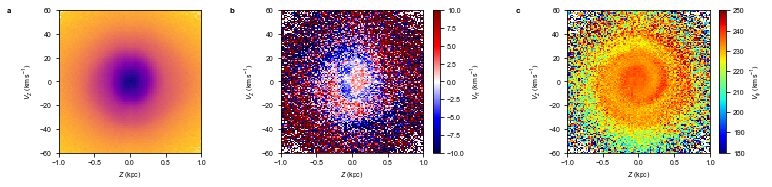

In [16]:
namef="~/Athens_School_2022/Gaia/fig1.png"

fig=plt.figure(figsize=cm2inch(23*18.3/15, 5.5*18.3/15))


ax0 = plt.axes([0.06, 0.2, 0.23, 0.75])  # standard axes
ax1 = plt.axes([0.36, 0.2, 0.23, 0.75])
ax2 = plt.axes([0.72, 0.2, 0.23, 0.75])

nn=0.35

rangex=[-1.2,1.2]
rangey=[-80,80]
binsx=80
binsy=90
rangex=[-1.,1.]
rangey=[-60,60]
binsx=80
binsy=90


aspect=(rangex[1]-rangex[0])/(rangey[1]-rangey[0])
print(aspect)

deltax=(rangex[1]-rangex[0])/(binsx*1.)
deltay=(rangey[1]-rangey[0])/(binsy*1.)
print(rangex[1]-rangex[0],rangey[1]-rangey[0])
print(deltax,deltay)

left=-0.33
top=1.02

z=ax0.hist2d(df['Z'], df['VZ'],bins=[binsx,binsy], norm=mcolors.PowerNorm(nn),range=[rangex,rangey], cmap=mycolormap)#, cmap='jet'
ax0.text(left, top, 'a',horizontalalignment='right', verticalalignment='top', transform=ax0.transAxes
         , fontweight='bold',bbox={'facecolor':'white', 'alpha':0.4, 'pad':4,'edgecolor':'none'},fontsize=8)
ax0.set_aspect(aspect)
ax0.set_xlabel('$Z$ (kpc)',fontname='Arial')
ax0.set_ylabel('$V_Z$ (km$\,$s$^{-1}$)')
ax0.set_xticks([-1,-0.5,0.,0.5,1.])

im=np.flip(stat2.statistic.T*1.,0)
im1=ax1.imshow(im,cmap='seismic', extent=[rangex[0],rangex[1],rangey[0],rangey[1]]
               ,aspect=aspect,vmin=-10,vmax=10)
fig.colorbar(im1,ax=ax1,label='$V_R$ (km$\,$s$^{-1}$)')

ax1.set_xticks([-1,-0.5,0.,0.5,1.])
ax1.set_xlabel('$Z$ (kpc)')
ax1.set_ylabel('$V_Z$ (km$\,$s$^{-1}$)')
ax1.text(left, top, 'b',horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes
         ,bbox={'facecolor':'white', 'alpha':0.6, 'pad':4,'edgecolor':'none'}, fontweight='bold',fontsize=8)

im2=ax2.imshow(np.flip(stat.statistic.T,0),cmap='jet', extent=[rangex[0],rangex[1],rangey[0],rangey[1]]
               ,aspect=aspect,vmin=180,vmax=250)
fig.colorbar(im2,ax=ax2,label='$V_\phi$ (km$\,$s$^{-1}$)')
ax2.set_xlabel('$Z$ (kpc)')
ax2.set_ylabel('$V_Z$ (km$\,$s$^{-1}$)')
ax2.text(left, top, 'c',horizontalalignment='right', verticalalignment='top', transform=ax2.transAxes
         ,bbox={'facecolor':'white', 'alpha':0.6, 'pad':4,'edgecolor':'none'}, fontweight='bold',fontsize=8)
ax2.set_xticks([-1,-0.5,0.,0.5,1.])


plt.savefig(namef, format='png', dpi=300)
plt.show()

(0.01, 1.0, 900.0, 300.0)


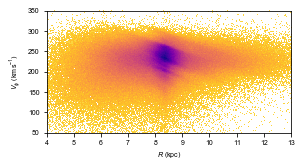

In [17]:
namef="~/Athens_School_2022/Gaia/"

nn=0.35

plt.figure(figsize=cm2inch(8.9*1.2, 5*1.2))

ax0 = plt.subplot2grid((1, 1), (0, 0))

rangex=[-1.2,1.2]
rangey=[-80,80]
binsx=80
binsy=90

rangex=[4,13]
rangey=[50,350]
deltax=0.01
deltay=1.
binsx=(rangex[1]-rangex[0])/deltax
binsy=(rangey[1]-rangey[0])/deltay
print(deltax,deltay,binsx,binsy)
z=ax0.hist2d(df['R'], df['Vphi'],bins=[binsx,binsy], norm=mcolors.PowerNorm(nn),range=[rangex,rangey], cmap=mycolormap)#, cmap='jet'
ax0.set_xlabel('$R$ (kpc)')
ax0.set_ylabel('$V_\phi$ (km$\,$s$^{-1}$)')
ax0.set_aspect(0.015)

plt.tight_layout()

plt.savefig(namef,  format='png', dpi=300)
plt.show()

/Users/tantoja/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:1428: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


(1, 1)


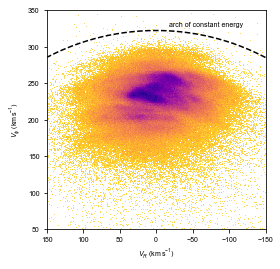

In [18]:
namef="~/Athens_School_2022/Gaia/fig3.png"

nn=0.5

fig = plt.figure(figsize=(7.2*1.5,2.5*1.5))

import matplotlib.gridspec
gskw = dict(width_ratios = [1],height_ratios= [1])
gs = matplotlib.gridspec.GridSpec(1,1, **gskw)
ax0=fig.add_subplot(gs[0], aspect="equal",adjustable='box-forced')

nn=0.45
rangex=[-150,150]
rangey=[50,350]
rangez=[-150,150]
binsx=300
deltax=(rangex[1]-rangex[0])/binsx
deltay=(rangey[1]-rangey[0])/binsx
print(deltax,deltay)

left=-0.24
top=1.02

VR=np.arange(-150,150,1)
E=52000
VPHI=np.sqrt((E/0.5)-VR*VR)

counts, xedges, yedges,im0=ax0.hist2d(dfRs['Vr'], dfRs['Vphi'],bins=[binsx,binsx], 
                label='',norm=mcolors.PowerNorm(nn),range=[rangex,rangey], cmap=mycolormap)#, cmap='jet'
ax0.set_xlim(150,-150)
ax0.plot(VR,VPHI,'k',linestyle='--')
ax0.text(0.9, 0.95, 'arch of constant energy',horizontalalignment='right', verticalalignment='top', transform=ax0.transAxes,fontsize=7)
ax0.set_xlabel('$V_R$ (km$\,$s$^{-1}$)')
ax0.set_ylabel('$V_\phi$ (km$\,$s$^{-1}$)')
ax0.set_aspect('equal')
ax0.set_xticks([-150,-100.,-50,0,50,100,150])

gs.tight_layout(fig, rect=[0,0., 1., 1.])


plt.savefig(namef,format='png', dpi=300)

plt.show()

In [19]:
dfRs['Vtot']=np.sqrt(dfRs['Vr']*dfRs['Vr']+(dfRs['Vphi']-232.)*(dfRs['Vphi']-232.)+dfRs['VZ']*dfRs['VZ'])
dfhalo=dfRs[abs(dfRs['Vtot'])>210.].copy()
print(len(dfhalo))

2949


(2, 2)


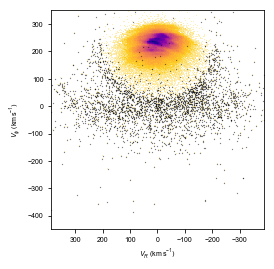

In [20]:
namef="~/Athens_School_2022/Gaia/fig4.png"

nn=0.5

fig = plt.figure(figsize=(7.2*1.5,2.5*1.5))

import matplotlib.gridspec
gskw = dict(width_ratios = [1],height_ratios= [1])
gs = matplotlib.gridspec.GridSpec(1,1, **gskw)
ax0=fig.add_subplot(gs[0], aspect="equal",adjustable='box-forced')

nn=0.45
rangex=[-390,390]
rangey=[-450,350]
rangez=[-150,150]
binsx=300
deltax=(rangex[1]-rangex[0])/binsx
deltay=(rangey[1]-rangey[0])/binsx
print(deltax,deltay)

left=-0.24
top=1.02

VR=np.arange(-150,150,1)
E=52000
VPHI=np.sqrt((E/0.5)-VR*VR)

counts, xedges, yedges,im0=ax0.hist2d(dfRs['Vr'], dfRs['Vphi'],bins=[binsx,binsx], 
                label='',norm=mcolors.PowerNorm(nn),range=[rangex,rangey], cmap=mycolormap)#, cmap='jet'
ax0.plot(dfhalo['Vr'], dfhalo['Vphi'],'o',markersize=0.2,color='k')
ax0.set_xlim(390,-390)
ax0.set_xlabel('$V_R$ (km$\,$s$^{-1}$)')
ax0.set_ylabel('$V_\phi$ (km$\,$s$^{-1}$)')
ax0.set_aspect('equal')
#ax0.set_xticks([-150,-100.,-50,0,50,100,150])

gs.tight_layout(fig, rect=[0,0., 1., 1.])


plt.savefig(namef,format='png', dpi=300)

plt.show()

(2, 2)


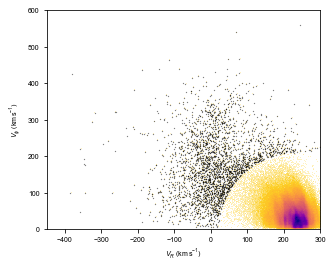

In [21]:
namef="~/Athens_School_2022/Gaia/fig5.png"

nn=0.5

fig = plt.figure(figsize=(7.2*1.5,2.5*1.5))

import matplotlib.gridspec
gskw = dict(width_ratios = [1],height_ratios= [1])
gs = matplotlib.gridspec.GridSpec(1,1, **gskw)
ax0=fig.add_subplot(gs[0], aspect="equal",adjustable='box-forced')

nn=0.45
rangex=[-450,300]
rangey=[0,600]
binsx=300
deltax=(rangex[1]-rangex[0])/binsx
deltay=(rangey[1]-rangey[0])/binsx
print(deltax,deltay)

left=-0.24
top=1.02

VR=np.arange(-150,150,1)
E=52000
VPHI=np.sqrt((E/0.5)-VR*VR)

counts, xedges, yedges,im0=ax0.hist2d(dfRs['Vphi'], np.sqrt(dfRs['Vr']*dfRs['Vr']+dfRs['VZ']*dfRs['VZ']),bins=[binsx,binsx], 
                label='',norm=mcolors.PowerNorm(nn),range=[rangex,rangey], cmap=mycolormap)#, cmap='jet'
ax0.plot(dfhalo['Vphi'], np.sqrt(dfhalo['Vr']*dfhalo['Vr']+dfhalo['VZ']*dfhalo['VZ']),'o',markersize=0.2,color='k')
ax0.set_xlabel('$V_R$ (km$\,$s$^{-1}$)')
ax0.set_ylabel('$V_\phi$ (km$\,$s$^{-1}$)')
ax0.set_aspect('equal')
#ax0.set_xticks([-150,-100.,-50,0,50,100,150])

gs.tight_layout(fig, rect=[0,0., 1., 1.])


plt.savefig(namef,format='png', dpi=300)

plt.show()